# WBC Multi-class Classification Notebook
This notebook consolidates data loading, model definition, training, evaluation utilities, and HDF5 export for the white blood cell classification project. Run each section sequentially.

### Additional Evaluation Metrics (F1-score, Precision, Recall)

In [21]:
# Core imports
import os
import math

from PIL import Image
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms

from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import h5py

print('Imports OK. Torch version:', torch.__version__)

Imports OK. Torch version: 2.9.0+cu126


### Upload and Extract Dataset


In [22]:
from google.colab import files
import zipfile
import os

# Define the target directory for extraction, consistent with DATA_DIR
dataset_target_dir = './bloodcells_dataset'
os.makedirs(dataset_target_dir, exist_ok=True)

uploaded = files.upload()

for fn in uploaded.keys():
    print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')
    # Save the uploaded file temporarily
    with open(fn, 'wb') as f:
        f.write(uploaded[fn])

    # Extract the zip file
    if zipfile.is_zipfile(fn):
        with zipfile.ZipFile(fn, 'r') as zip_ref:
            zip_ref.extractall(dataset_target_dir)
        print(f'Successfully extracted "{fn}" to "{dataset_target_dir}"')
        # Clean up the uploaded zip file
        os.remove(fn)
    else:
        print(f'Error: "{fn}" is not a valid zip file.')

# Verify the contents of the extracted directory
print(f"Contents of '{dataset_target_dir}':")
for root, dirs, files in os.walk(dataset_target_dir):
    level = root.replace(dataset_target_dir, '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        print(f'{subindent}{f}')


Contents of './bloodcells_dataset':
bloodcells_dataset/
    bloodcells_dataset/
        platelet/
            PLATELET_677848.jpg
            PLATELET_24323.jpg
            PLATELET_401976.jpg
            PLATELET_374765.jpg
            PLATELET_675079.jpg
            PLATELET_829786.jpg
            PLATELET_844459.jpg
            PLATELET_351810.jpg
            PLATELET_624944.jpg
            PLATELET_940150.jpg
            PLATELET_388181.jpg
            PLATELET_939648.jpg
            PLATELET_182955.jpg
            PLATELET_831123.jpg
            PLATELET_435521.jpg
            PLATELET_398177.jpg
            PLATELET_648633.jpg
            PLATELET_410573.jpg
            PLATELET_519576.jpg
            PLATELET_939662.jpg
            PLATELET_513021.jpg
            PLATELET_337552.jpg
            PLATELET_996043.jpg
            PLATELET_580349.jpg
            PLATELET_172457.jpg
            PLATELET_796209.jpg
            PLATELET_447718.jpg
            PLATELET_384325.jpg
       

## Dataset and Transforms

In [23]:
def default_transforms(train=True, image_size=224):
    if train:
        return transforms.Compose([
            transforms.RandomResizedCrop(image_size, scale=(0.9, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(360),
            transforms.ColorJitter(brightness=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    else:
        return transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])


class BloodcellDataset(Dataset):
    """Loads blood cell images from class-organized folders."""
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform or default_transforms(train=True)
        classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
        if not classes:
            raise RuntimeError(f"No class folders found in {data_dir}")
        self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
        self.samples = []
        for cls in classes:
            cls_dir = os.path.join(data_dir, cls)
            for fname in os.listdir(cls_dir):
                path = os.path.join(cls_dir, fname)
                if os.path.isfile(path) and fname.lower().endswith((".png", ".jpg", ".jpeg", ".bmp")):
                    self.samples.append((path, self.class_to_idx[cls]))
        if not self.samples:
            raise RuntimeError(f"No image files found under {data_dir}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        with Image.open(path) as img:
            img = img.convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

## Model Definition (WBCNet)

In [24]:
def conv_block(in_ch, out_ch, kernel_size=3, padding=1, use_bn=True):
    layers = [nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding=padding), nn.ReLU(inplace=True)]
    if use_bn:
        layers.insert(1, nn.BatchNorm2d(out_ch))
    return nn.Sequential(*layers)


class WBCNet(nn.Module):
    """Custom CNN with five convolutional stages."""
    def __init__(self, num_classes=8, dropout=0.5):
        super().__init__()
        self.features = nn.Sequential(
            conv_block(3, 32),
            conv_block(32, 32),
            nn.MaxPool2d(2),

            conv_block(32, 64),
            conv_block(64, 64),
            nn.MaxPool2d(2),

            conv_block(64, 128),
            conv_block(128, 128),
            nn.MaxPool2d(2),

            conv_block(128, 256),
            conv_block(256, 256),
            nn.MaxPool2d(2),

            conv_block(256, 512),
            conv_block(512, 512),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


def build_model(num_classes=8, device=None):
    model = WBCNet(num_classes=num_classes)
    if device is not None:
        model = model.to(device)
    return model

## Training Utilities

In [25]:
import json
from datetime import datetime, UTC

def save_checkpoint(state, is_best, save_dir, filename="checkpoint.pth.tar"):
    """Persist training state and keep wbcnet_best_state artifacts when validation improves."""
    os.makedirs(save_dir, exist_ok=True)
    path = os.path.join(save_dir, filename)
    torch.save(state, path)
    if is_best and state.get("state_dict") is not None:
        best_ckpt_path = os.path.join(save_dir, "wbcnet_best_state.pth.tar")
        torch.save(state, best_ckpt_path)
        h5_path = os.path.join(save_dir, "wbcnet_best_state.h5")
        save_state_dict_to_h5(state["state_dict"], h5_path)
        meta_path = os.path.join(save_dir, "wbcnet_best_state.json")
        with open(meta_path, "w", encoding="utf-8") as fp:
            json.dump(
                {
                    "epoch": state.get("epoch"),
                    "val_loss": float(state.get("val_loss", 0.0)),
                    "val_acc": float(state.get("val_acc", 0.0)),
                    "updated_at": datetime.now(UTC).isoformat(),
                },
                fp,
                indent=2,
            )

def compute_accuracy(outputs, targets):
    preds = torch.argmax(outputs, dim=1).cpu().numpy()
    targets = targets.cpu().numpy()
    return accuracy_score(targets, preds)

def save_state_dict_to_h5(state_dict, out_path):
    os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)
    with h5py.File(out_path, "w") as f:
        for name, tensor in state_dict.items():
            array = tensor.detach().cpu().numpy() if isinstance(tensor, torch.Tensor) else np.array(tensor)
            dataset_name = name.lstrip("/")
            try:
                f.create_dataset(dataset_name, data=array, compression="gzip")
            except Exception:
                f.create_dataset(dataset_name, data=array)

def load_state_dict_from_h5(h5_path):
    state = {}
    with h5py.File(h5_path, "r") as f:
        for name in f.keys():
            state[name] = torch.from_numpy(np.array(f[name][()]))
    return state


## Training Loop

In [26]:
def train_model(
    data_dir,
    epochs=10,
    batch_size=32,
    lr=1e-3,
    optimizer_name="adam",
    save_dir="./checkpoints",
    val_split=0.15,
    num_workers=0,
    device=None,
    patience=15,
    return_history=False,
    train_subset_fraction=1.0,
    val_subset_fraction=1.0,
):
    device = torch.device(device if device else ("cuda" if torch.cuda.is_available() else "cpu"))
    full_dataset = BloodcellDataset(data_dir, transform=default_transforms(train=True))
    num_classes = len(full_dataset.class_to_idx)
    val_size = int(len(full_dataset) * val_split)
    train_size = len(full_dataset) - val_size
    train_set, val_set = random_split(full_dataset, [train_size, val_size])
    val_set.dataset.transform = default_transforms(train=False)
    if train_subset_fraction < 1.0:
        sub_len = max(1, int(len(train_set) * train_subset_fraction))
        train_set = Subset(train_set.dataset, train_set.indices[:sub_len])
    if val_subset_fraction < 1.0:
        sub_len = max(1, int(len(val_set) * val_subset_fraction))
        val_set = Subset(val_set.dataset, val_set.indices[:sub_len])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    model = build_model(num_classes=num_classes, device=device)
    criterion = nn.CrossEntropyLoss()
    if optimizer_name.lower() == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name.lower() == "adamw":
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)
    best_val_loss = float("inf")
    best_val_acc = 0.0
    best_epoch = 0
    history = []
    os.makedirs(save_dir, exist_ok=True)
    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        acc_total = 0.0
        for imgs, labels in tqdm(train_loader, desc=f"train {epoch}/{epochs}", leave=False):
            imgs = imgs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * imgs.size(0)
            acc_total += compute_accuracy(outputs, labels) * imgs.size(0)
        train_loss = running_loss / len(train_loader.dataset) if len(train_loader.dataset) else 0.0
        train_acc = acc_total / len(train_loader.dataset) if len(train_loader.dataset) else 0.0
        model.eval()
        running_loss = 0.0
        acc_total = 0.0
        with torch.no_grad():
            for imgs, labels in tqdm(val_loader, desc=f"val {epoch}/{epochs}", leave=False):
                imgs = imgs.to(device)
                labels = labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * imgs.size(0)
                acc_total += compute_accuracy(outputs, labels) * imgs.size(0)
        val_size_denom = len(val_loader.dataset) if len(val_loader.dataset) else 1
        val_loss = running_loss / val_size_denom
        val_acc = acc_total / val_size_denom
        scheduler.step(val_loss)
        print(
            f"Epoch {epoch}/{epochs} | "
            f"train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | "
            f"val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}",
        )
        history.append(
            {
                "epoch": epoch,
                "train_loss": float(train_loss),
                "train_acc": float(train_acc),
                "val_loss": float(val_loss),
                "val_acc": float(val_acc),
                "lr": float(optimizer.param_groups[0]["lr"]),
            }
        )
        is_best = val_loss < best_val_loss
        if is_best:
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_epoch = epoch
        state = {
            "epoch": epoch,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "val_loss": val_loss,
            "val_acc": val_acc,
        }
        save_checkpoint(state, is_best, save_dir, filename=f"checkpoint_epoch_{epoch:03d}.pth.tar")
        if epoch - best_epoch > patience:
            print("Early stopping triggered")
            break
    summary = {
        "best_val_loss": float(best_val_loss),
        "best_val_acc": float(best_val_acc),
        "best_epoch": int(best_epoch),
        "epochs_ran": len(history),
        "config": {
            "data_dir": data_dir,
            "epochs": epochs,
            "batch_size": batch_size,
            "lr": lr,
            "optimizer": optimizer_name,
            "val_split": val_split,
            "train_subset_fraction": train_subset_fraction,
            "val_subset_fraction": val_subset_fraction,
        },
        "generated_at": datetime.utcnow().isoformat() + "Z",
    }
    history_path = os.path.join(save_dir, "training_history.json")
    with open(history_path, "w", encoding="utf-8") as fp:
        json.dump({"summary": summary, "history": history}, fp, indent=2)
    summary_path = os.path.join(save_dir, "training_summary.json")
    with open(summary_path, "w", encoding="utf-8") as fp:
        json.dump(summary, fp, indent=2)
    print(
        f"Training complete. Best validation loss {best_val_loss:.4f} at epoch {best_epoch} "
        f"with val accuracy {best_val_acc:.4f}"
    )
    if return_history:
        return model, full_dataset.class_to_idx, history
    return model, full_dataset.class_to_idx

## CNN Training

In [27]:
FULL_TRAIN_CONFIG = {
    "epochs": 20,
    "batch_size": 32,
    "lr": 1e-3,
    "optimizer_name": "adamw",
    "val_split": 0.15,
    "patience": 8,
}

SAVE_DIR = "./checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

# DATA_DIR to point to the actual dataset root
DATA_DIR = "./bloodcells_dataset/bloodcells_dataset"
if not os.path.isdir(DATA_DIR):
    raise FileNotFoundError(
        f"DATA_DIR path '{DATA_DIR}' is missing. Update the path so it points to the blood cell dataset root."
    )

model, class_to_idx, history = train_model(
    DATA_DIR,
    epochs=FULL_TRAIN_CONFIG["epochs"],
    batch_size=FULL_TRAIN_CONFIG["batch_size"],
    lr=FULL_TRAIN_CONFIG["lr"],
    optimizer_name=FULL_TRAIN_CONFIG["optimizer_name"],
    save_dir=SAVE_DIR,
    val_split=FULL_TRAIN_CONFIG["val_split"],
    patience=FULL_TRAIN_CONFIG["patience"],
    num_workers=0,
    return_history=True,
)

if history:
    best_epoch_entry = max(history, key=lambda entry: entry["val_acc"])
    print(
        f"Best validation accuracy: {best_epoch_entry['val_acc']:.4f} at epoch {best_epoch_entry['epoch']}"
    )
else:
    print("Training history is empty; check dataset configuration.")

Epoch 1/20 | train_loss: 0.6738 train_acc: 0.7676 | val_loss: 1.0824 val_acc: 0.7167


Epoch 2/20 | train_loss: 0.3528 train_acc: 0.8782 | val_loss: 0.8794 val_acc: 0.7682


Epoch 3/20 | train_loss: 0.2928 train_acc: 0.9058 | val_loss: 0.7606 val_acc: 0.7831


Epoch 4/20 | train_loss: 0.2309 train_acc: 0.9224 | val_loss: 0.8811 val_acc: 0.7858


Epoch 5/20 | train_loss: 0.2077 train_acc: 0.9309 | val_loss: 0.1437 val_acc: 0.9512


Epoch 6/20 | train_loss: 0.1804 train_acc: 0.9394 | val_loss: 0.1877 val_acc: 0.9364


Epoch 7/20 | train_loss: 0.1656 train_acc: 0.9442 | val_loss: 0.1057 val_acc: 0.9629


Epoch 8/20 | train_loss: 0.1530 train_acc: 0.9509 | val_loss: 0.1438 val_acc: 0.9512


Epoch 9/20 | train_loss: 0.1548 train_acc: 0.9497 | val_loss: 0.1702 val_acc: 0.9423


Epoch 10/20 | train_loss: 0.1270 train_acc: 0.9590 | val_loss: 0.0860 val_acc: 0.9715


Epoch 11/20 | train_loss: 0.1311 train_acc: 0.9576 | val_loss: 0.1591 val_acc: 0.9516


Epoch 12/20 | train_loss: 0.1311 train_acc: 0.9592 | val_loss: 0.1426 val_acc: 0.9497


Epoch 13/20 | train_loss: 0.1142 train_acc: 0.9641 | val_loss: 0.1644 val_acc: 0.9450


Epoch 14/20 | train_loss: 0.1135 train_acc: 0.9626 | val_loss: 0.0643 val_acc: 0.9789


Epoch 15/20 | train_loss: 0.1048 train_acc: 0.9672 | val_loss: 0.0730 val_acc: 0.9754


Epoch 16/20 | train_loss: 0.1034 train_acc: 0.9667 | val_loss: 0.1038 val_acc: 0.9653


Epoch 17/20 | train_loss: 0.0953 train_acc: 0.9699 | val_loss: 0.0877 val_acc: 0.9746


Epoch 18/20 | train_loss: 0.1015 train_acc: 0.9681 | val_loss: 0.0833 val_acc: 0.9762


Epoch 19/20 | train_loss: 0.0974 train_acc: 0.9686 | val_loss: 0.1671 val_acc: 0.9485


Epoch 20/20 | train_loss: 0.0841 train_acc: 0.9718 | val_loss: 0.1020 val_acc: 0.9668
Training complete. Best validation loss 0.0643 at epoch 14 with val accuracy 0.9789
Best validation accuracy: 0.9789 at epoch 14


/tmp/ipython-input-629544223.py:122: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "generated_at": datetime.utcnow().isoformat() + "Z",


### Additional Evaluation Metrics (F1-score, Precision, Recall)

In [32]:
from sklearn.metrics import classification_report

# Assuming all_labels and all_preds are available from the previous evaluation cell
# If not, ensure the evaluation cell is run first or redefine them here.

# Generate the classification report
report = classification_report(all_labels_np, all_preds_np, target_names=[idx_to_class[i] for i in sorted(idx_to_class.keys())])

print("\nClassification Report:\n")
print(report)



Classification Report:

              precision    recall  f1-score   support

    basophil       0.98      0.99      0.99       180
  eosinophil       1.00      1.00      1.00       467
erythroblast       1.00      0.97      0.98       218
          ig       0.96      0.96      0.96       450
  lymphocyte       0.96      0.99      0.98       196
    monocyte       0.97      0.95      0.96       238
  neutrophil       0.98      0.99      0.98       480
    platelet       1.00      1.00      1.00       334

    accuracy                           0.98      2563
   macro avg       0.98      0.98      0.98      2563
weighted avg       0.98      0.98      0.98      2563



## Save the trained model in HDF5 format

In [28]:
BEST_EXPORT_DIR = os.path.join(SAVE_DIR, "final_exports")
os.makedirs(BEST_EXPORT_DIR, exist_ok=True)

best_ckpt_path = os.path.join(SAVE_DIR, "wbcnet_best_state.pth.tar")
if not os.path.exists(best_ckpt_path):
    raise FileNotFoundError(
        "Best checkpoint not found. Re-run the training cell so wbcnet_best_state.pth.tar is created."
    )

checkpoint = torch.load(best_ckpt_path, map_location="cpu")
best_state_dict = checkpoint.get("state_dict", checkpoint)

best_pt_path = os.path.join(BEST_EXPORT_DIR, "wbcnet_best_state.pth")
torch.save(best_state_dict, best_pt_path)
print(f"Saved best state_dict to {best_pt_path}")

best_h5_path = os.path.join(BEST_EXPORT_DIR, "wbcnet_best_state.h5")
save_state_dict_to_h5(best_state_dict, best_h5_path)
print(f"Saved best weights to {best_h5_path}")

Saved best state_dict to ./checkpoints/final_exports/wbcnet_best_state.pth
Saved best weights to ./checkpoints/final_exports/wbcnet_best_state.h5


## Evaluate Saved HDF5 Model
This cell loads `checkpoints/wbcnet_best_state.h5`, restores the model weights, and reports validation accuracy plus a confusion matrix. Adjust `h5_path` if your checkpoint lives elsewhere.

In [29]:
if 'BloodcellDataset' not in globals() or 'default_transforms' not in globals():
    from dataset import BloodcellDataset, default_transforms
if 'build_model' not in globals():
    from model import build_model
if 'load_state_dict_from_h5' not in globals():
    from utils import load_state_dict_from_h5

DATA_DIR = "./bloodcells_dataset/bloodcells_dataset"
SAVE_DIR = globals().get("SAVE_DIR", "./checkpoints")
h5_path = os.path.join(SAVE_DIR, "wbcnet_best_state.h5")
if not os.path.exists(h5_path):
    raise FileNotFoundError(
        f"HDF5 file not found: {h5_path}. Run the smoke test or update the path."
    )

eval_dataset = BloodcellDataset(DATA_DIR, transform=default_transforms(train=False))
num_classes = len(eval_dataset.class_to_idx)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = build_model(num_classes=num_classes, device=device)
state_dict = load_state_dict_from_h5(h5_path)
model.load_state_dict(state_dict)
model.eval()

val_split = 0.15
val_size = int(len(eval_dataset) * val_split)
train_size = len(eval_dataset) - val_size
train_subset, val_subset = random_split(
    eval_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42)
 )
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=4)

all_preds = []
all_labels = []
with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="eval", leave=False):
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.numpy())

all_preds = np.concatenate(all_preds) if all_preds else np.array([])
all_labels = np.concatenate(all_labels) if all_labels else np.array([])
if all_preds.size == 0:
    print("Validation subset is empty; adjust val_split or dataset path.")
else:
    accuracy = (all_preds == all_labels).mean()
    cm = confusion_matrix(all_labels, all_preds)
    print(f"Validation accuracy: {accuracy:.4f}")
    print("Confusion matrix:\n", cm)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
                                                     

Validation accuracy: 0.9856
Confusion matrix:
 [[185   1   0   0   1   0   0   0]
 [  0 448   0   0   0   0   0   0]
 [  0   0 231   1   1   1   0   0]
 [  1   0   1 413   0   4   6   0]
 [  0   0   0   0 200   1   1   0]
 [  0   1   0   5   3 209   0   0]
 [  1   0   0   6   0   1 465   0]
 [  0   0   0   0   1   0   0 375]]


## MODEL PREDICTIONS ON VALIDATION DATA


MODEL PREDICTIONS ON VALIDATION DATA



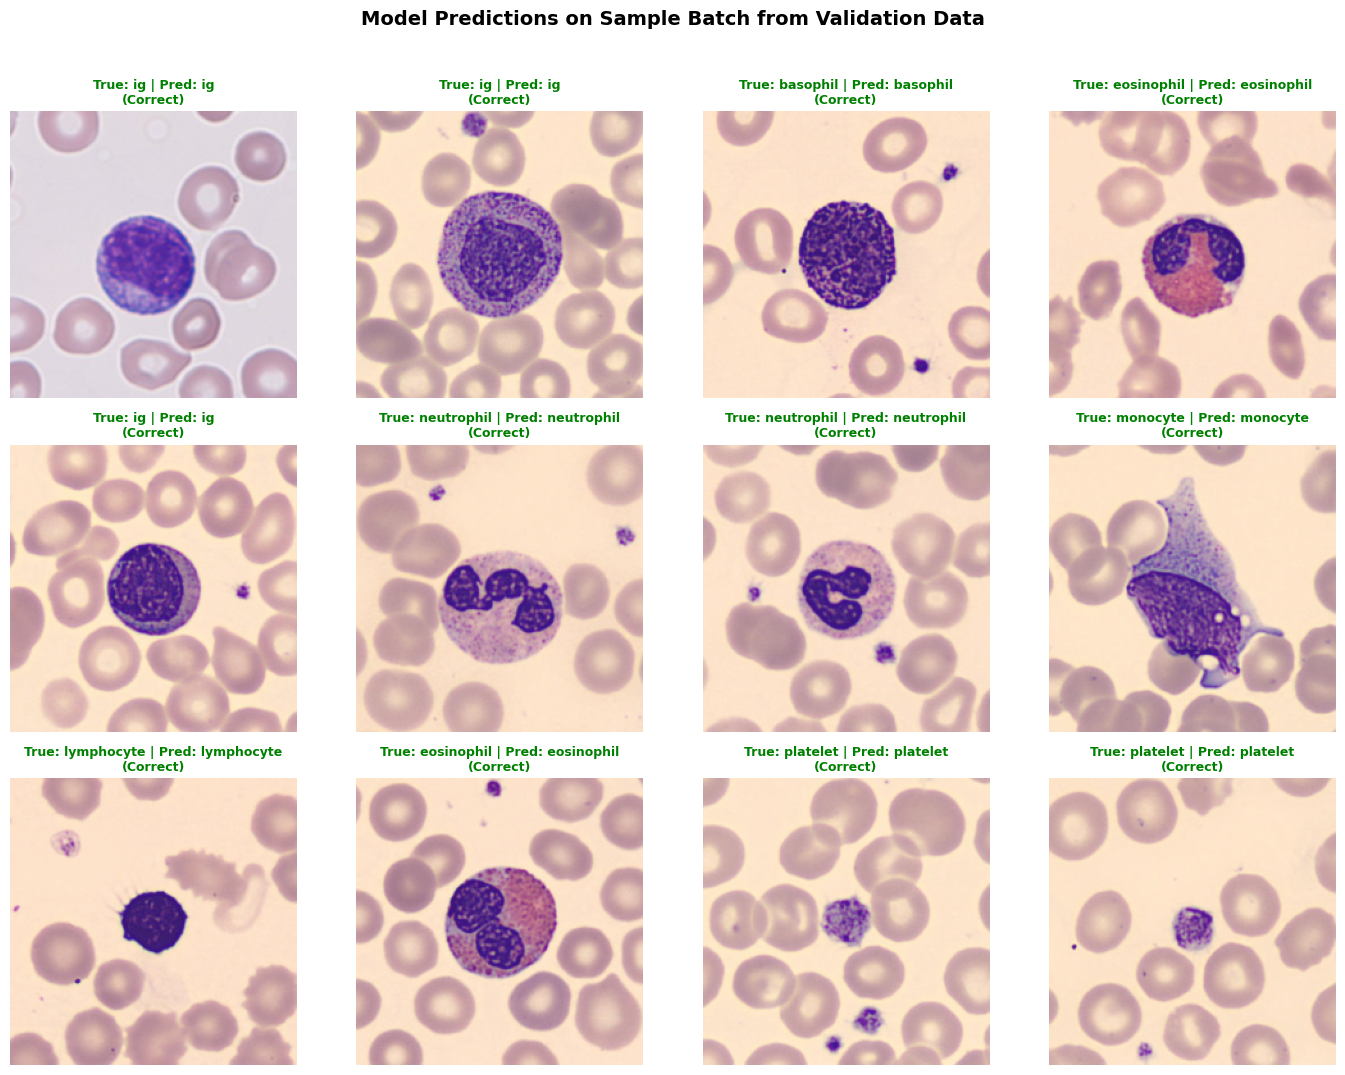


[OK] Batch Accuracy: 100.00% (32/32 correct)
  Displayed 12 predictions with True vs Predicted labels

Per-class performance across the validation subset:
  - basophil: 179/180 (99.44%)
  - eosinophil: 466/467 (99.79%)
  - erythroblast: 211/218 (96.79%)
  - ig: 431/450 (95.78%)
  - lymphocyte: 195/196 (99.49%)
  - monocyte: 225/238 (94.54%)
  - neutrophil: 473/480 (98.54%)
  - platelet: 334/334 (100.00%)


In [30]:
import math
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split

print("\n" + "=" * 60)
print("MODEL PREDICTIONS ON VALIDATION DATA")
print("=" * 60 + "\n")

DATA_DIR = "./bloodcells_dataset/bloodcells_dataset"
SAVE_DIR = globals().get("SAVE_DIR", "./checkpoints")

if "BloodcellDataset" not in globals() or "default_transforms" not in globals():
    from dataset import BloodcellDataset, default_transforms
if "build_model" not in globals():
    from model import build_model
if "load_state_dict_from_h5" not in globals():
    from utils import load_state_dict_from_h5

eval_dataset = BloodcellDataset(DATA_DIR, transform=default_transforms(train=False))
if len(eval_dataset) < 2:
    raise RuntimeError("Need at least two samples to create a validation split.")

class_to_idx = eval_dataset.class_to_idx
idx_to_class = {idx: name for name, idx in class_to_idx.items()}
class_names = [idx_to_class[idx] for idx in range(len(idx_to_class))]

val_split = 0.15
val_size = max(1, int(len(eval_dataset) * val_split))
val_size = min(val_size, len(eval_dataset) - 1)
if val_size <= 0:
    raise RuntimeError("Validation split produced no samples; adjust val_split or expand the dataset.")
train_size = len(eval_dataset) - val_size
_, val_subset = random_split(
    eval_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(123),
)

viz_loader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=0)
if len(viz_loader) == 0:
    raise RuntimeError("Validation loader produced no batches; adjust split parameters.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if "model" not in globals() or not isinstance(model, nn.Module):
    model = build_model(num_classes=len(class_names), device=device)
    h5_path = os.path.join(SAVE_DIR, "wbcnet_best_state.h5")
    if not os.path.exists(h5_path):
        raise FileNotFoundError(f"HDF5 file not found: {h5_path}. Run training/evaluation to create it.")
    state_dict = load_state_dict_from_h5(h5_path)
    model.load_state_dict(state_dict)
else:
    model = model.to(device)
model.eval()

all_preds = []
all_labels = []
batch_images = None
batch_labels = None
batch_preds = None

with torch.no_grad():
    for batch_idx, (imgs_cpu, labels_cpu) in enumerate(viz_loader):
        imgs_device = imgs_cpu.to(device)
        logits = model(imgs_device)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels_cpu.numpy())
        if batch_idx == 0:
            batch_images = imgs_cpu
            batch_labels = labels_cpu.numpy()
            batch_preds = preds

if batch_images is None or batch_preds is None:
    raise RuntimeError("Could not extract the first validation batch; verify the dataset contents.")

all_preds_np = np.concatenate(all_preds) if all_preds else np.array([])
all_labels_np = np.concatenate(all_labels) if all_labels else np.array([])
if all_preds_np.size == 0:
    print("Validation subset is empty; adjust val_split or dataset path.")
    raise SystemExit

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

num_samples_to_plot = min(12, batch_images.shape[0])
cols = 4
rows = math.ceil(num_samples_to_plot / cols)

plt.figure(figsize=(14, 3.5 * rows))
for i in range(num_samples_to_plot):
    plt.subplot(rows, cols, i + 1)
    image = batch_images[i].permute(1, 2, 0).numpy()
    image = (image * std) + mean
    image = np.clip(image, 0.0, 1.0)

    true_label = class_names[batch_labels[i]]
    pred_label = class_names[batch_preds[i]]
    is_correct = batch_labels[i] == batch_preds[i]
    title_color = "green" if is_correct else "red"
    status = "(Correct)" if is_correct else "(WRONG)"
    title_text = f"True: {true_label} | Pred: {pred_label}\n{status}"

    plt.imshow(image)
    plt.title(title_text, fontsize=9, fontweight="bold", color=title_color)
    plt.axis("off")

plt.suptitle("Model Predictions on Sample Batch from Validation Data", y=1.02, fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

batch_correct = int((batch_preds == batch_labels).sum())
batch_accuracy = batch_correct / len(batch_labels)
print(f"\n[OK] Batch Accuracy: {batch_accuracy:.2%} ({batch_correct}/{len(batch_labels)} correct)")
print(f"  Displayed {num_samples_to_plot} predictions with True vs Predicted labels")

print("\nPer-class performance across the validation subset:")
for cls_idx, cls_name in enumerate(class_names):
    cls_mask = all_labels_np == cls_idx
    total = int(cls_mask.sum())
    if total == 0:
        print(f"  - {cls_name}: 0 samples in validation subset")
        continue
    cls_correct = int((all_preds_np[cls_mask] == cls_idx).sum())
    cls_acc = cls_correct / total
    print(f"  - {cls_name}: {cls_correct}/{total} ({cls_acc:.2%})")

## Hyperparameter Search

In [31]:
import itertools
import json
import time

if 'train_model' not in globals():
    from train import train_model
if 'BloodcellDataset' not in globals() or 'default_transforms' not in globals():
    from dataset import BloodcellDataset, default_transforms

DATA_DIR = globals().get("DATA_DIR", "./bloodcells_dataset")
SAVE_DIR = globals().get("SAVE_DIR", "./checkpoints")
os.makedirs(SAVE_DIR, exist_ok=True)

search_space = {
    "lr": [1e-3, 5e-4],
    "batch_size": [32, 64],
    "optimizer_name": ["adam", "adamw"],
}
sweep = list(itertools.product(*search_space.values()))
train_fraction = 0.4  # portion of training split to speed up sweeps
val_fraction = 0.6    # portion of validation split used per run

results = []
for idx, values in enumerate(sweep, start=1):
    config = dict(zip(search_space.keys(), values))
    run_save_dir = os.path.join(SAVE_DIR, f"tuning_run_{idx}")
    print(f"Run {idx}/{len(sweep)}: {config}")
    start_time = time.time()
    try:
        model, class_map, history = train_model(
            DATA_DIR,
            epochs=6,
            batch_size=config["batch_size"],
            lr=config["lr"],
            optimizer_name=config["optimizer_name"],
            save_dir=run_save_dir,
            val_split=0.2,
            num_workers=2,
            return_history=True,
            train_subset_fraction=train_fraction,
            val_subset_fraction=val_fraction,
        )
    except RuntimeError as err:
        print(f"Run {idx} failed: {err}")
        continue
    if not history:
        print(f"Run {idx} produced no history; skipping")
        continue
    best_epoch = max(history, key=lambda h: h["val_acc"])
    elapsed_minutes = (time.time() - start_time) / 60.0
    results.append({
        "run_id": idx,
        **config,
        "train_subset_fraction": train_fraction,
        "val_subset_fraction": val_fraction,
        "best_epoch": best_epoch["epoch"],
        "best_val_acc": best_epoch["val_acc"],
        "best_val_loss": best_epoch["val_loss"],
        "epochs_trained": len(history),
        "final_val_acc": history[-1]["val_acc"],
        "duration_min": elapsed_minutes,
    })
    print(
        f"Run {idx} best val_acc={best_epoch['val_acc']:.4f} "
        f"val_loss={best_epoch['val_loss']:.4f} at epoch {best_epoch['epoch']}"
    )
    print(f"Approx. duration: {elapsed_minutes:.1f} min\n")

if results:
    results_sorted = sorted(results, key=lambda r: r["best_val_acc"], reverse=True)
    print("Top configurations by validation accuracy:")
    for entry in results_sorted:
        print(
            f"run {entry['run_id']}: lr={entry['lr']}, batch={entry['batch_size']}, ",
            f"optimizer={entry['optimizer_name']} -> best_val_acc={entry['best_val_acc']:.4f}",
        )
    results_path = os.path.join(SAVE_DIR, "tuning_results.json")
    with open(results_path, "w", encoding="utf-8") as fp:
        json.dump(results_sorted, fp, indent=2)
    print(f"Saved detailed results to {results_path}")
else:
    print("No successful hyperparameter runs recorded.")

Run 1/8: {'lr': 0.001, 'batch_size': 32, 'optimizer_name': 'adam'}


Epoch 1/6 | train_loss: 1.1672 train_acc: 0.5773 | val_loss: 1.1991 val_acc: 0.4580


Epoch 2/6 | train_loss: 0.8487 train_acc: 0.6831 | val_loss: 1.3007 val_acc: 0.5727


Epoch 3/6 | train_loss: 0.6860 train_acc: 0.7489 | val_loss: 0.6951 val_acc: 0.7420


Epoch 4/6 | train_loss: 0.6024 train_acc: 0.7859 | val_loss: 0.9577 val_acc: 0.6659


Epoch 5/6 | train_loss: 0.5157 train_acc: 0.8075 | val_loss: 1.4036 val_acc: 0.5493


/tmp/ipython-input-629544223.py:122: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "generated_at": datetime.utcnow().isoformat() + "Z",


Epoch 6/6 | train_loss: 0.4467 train_acc: 0.8438 | val_loss: 0.8189 val_acc: 0.7220
Training complete. Best validation loss 0.6951 at epoch 3 with val accuracy 0.7420
Run 1 best val_acc=0.7420 val_loss=0.6951 at epoch 3
Approx. duration: 4.3 min

Run 2/8: {'lr': 0.001, 'batch_size': 32, 'optimizer_name': 'adamw'}


Epoch 1/6 | train_loss: 1.1098 train_acc: 0.5941 | val_loss: 1.1636 val_acc: 0.5590


Epoch 2/6 | train_loss: 0.7063 train_acc: 0.7429 | val_loss: 1.8853 val_acc: 0.5341


Epoch 3/6 | train_loss: 0.5145 train_acc: 0.8108 | val_loss: 0.5441 val_acc: 0.8141


Epoch 4/6 | train_loss: 0.4422 train_acc: 0.8413 | val_loss: 0.3128 val_acc: 0.8995


Epoch 5/6 | train_loss: 0.3902 train_acc: 0.8614 | val_loss: 0.4294 val_acc: 0.8356


/tmp/ipython-input-629544223.py:122: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "generated_at": datetime.utcnow().isoformat() + "Z",


Epoch 6/6 | train_loss: 0.3574 train_acc: 0.8762 | val_loss: 1.2273 val_acc: 0.6224
Training complete. Best validation loss 0.3128 at epoch 4 with val accuracy 0.8995
Run 2 best val_acc=0.8995 val_loss=0.3128 at epoch 4
Approx. duration: 4.3 min

Run 3/8: {'lr': 0.001, 'batch_size': 64, 'optimizer_name': 'adam'}


Epoch 1/6 | train_loss: 0.8945 train_acc: 0.6800 | val_loss: 3.1244 val_acc: 0.5366


Epoch 2/6 | train_loss: 0.5229 train_acc: 0.8131 | val_loss: 2.8984 val_acc: 0.3888


Epoch 3/6 | train_loss: 0.4053 train_acc: 0.8663 | val_loss: 0.2944 val_acc: 0.9063


Epoch 4/6 | train_loss: 0.3040 train_acc: 0.8963 | val_loss: 3.2213 val_acc: 0.5688


Epoch 5/6 | train_loss: 0.3272 train_acc: 0.8939 | val_loss: 0.3655 val_acc: 0.8659


/tmp/ipython-input-629544223.py:122: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "generated_at": datetime.utcnow().isoformat() + "Z",


Epoch 6/6 | train_loss: 0.2406 train_acc: 0.9225 | val_loss: 1.3488 val_acc: 0.6156
Training complete. Best validation loss 0.2944 at epoch 3 with val accuracy 0.9063
Run 3 best val_acc=0.9063 val_loss=0.2944 at epoch 3
Approx. duration: 4.3 min

Run 4/8: {'lr': 0.001, 'batch_size': 64, 'optimizer_name': 'adamw'}


Epoch 1/6 | train_loss: 0.9701 train_acc: 0.6489 | val_loss: 3.0074 val_acc: 0.3712


Epoch 2/6 | train_loss: 0.5149 train_acc: 0.8248 | val_loss: 0.5871 val_acc: 0.7917


Epoch 3/6 | train_loss: 0.3527 train_acc: 0.8810 | val_loss: 0.4161 val_acc: 0.8537


Epoch 4/6 | train_loss: 0.2942 train_acc: 0.8985 | val_loss: 0.6240 val_acc: 0.7805


Epoch 5/6 | train_loss: 0.2746 train_acc: 0.9075 | val_loss: 0.7342 val_acc: 0.7980


/tmp/ipython-input-629544223.py:122: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "generated_at": datetime.utcnow().isoformat() + "Z",


Epoch 6/6 | train_loss: 0.2273 train_acc: 0.9216 | val_loss: 2.4454 val_acc: 0.4727
Training complete. Best validation loss 0.4161 at epoch 3 with val accuracy 0.8537
Run 4 best val_acc=0.8537 val_loss=0.4161 at epoch 3
Approx. duration: 4.3 min

Run 5/8: {'lr': 0.0005, 'batch_size': 32, 'optimizer_name': 'adam'}


Epoch 1/6 | train_loss: 0.8279 train_acc: 0.7089 | val_loss: 1.7231 val_acc: 0.5990


Epoch 2/6 | train_loss: 0.4378 train_acc: 0.8477 | val_loss: 0.9557 val_acc: 0.6605


Epoch 3/6 | train_loss: 0.3471 train_acc: 0.8857 | val_loss: 0.2561 val_acc: 0.9093


Epoch 4/6 | train_loss: 0.2790 train_acc: 0.9033 | val_loss: 0.5257 val_acc: 0.8244


Epoch 5/6 | train_loss: 0.2666 train_acc: 0.9102 | val_loss: 0.3529 val_acc: 0.8766


/tmp/ipython-input-629544223.py:122: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "generated_at": datetime.utcnow().isoformat() + "Z",


Epoch 6/6 | train_loss: 0.2265 train_acc: 0.9239 | val_loss: 1.0515 val_acc: 0.7098
Training complete. Best validation loss 0.2561 at epoch 3 with val accuracy 0.9093
Run 5 best val_acc=0.9093 val_loss=0.2561 at epoch 3
Approx. duration: 4.3 min

Run 6/8: {'lr': 0.0005, 'batch_size': 32, 'optimizer_name': 'adamw'}


Epoch 1/6 | train_loss: 0.7317 train_acc: 0.7460 | val_loss: 1.0023 val_acc: 0.6717


Epoch 2/6 | train_loss: 0.3962 train_acc: 0.8663 | val_loss: 0.5180 val_acc: 0.8298


Epoch 3/6 | train_loss: 0.3205 train_acc: 0.8941 | val_loss: 0.8749 val_acc: 0.7434


Epoch 4/6 | train_loss: 0.2658 train_acc: 0.9113 | val_loss: 0.3544 val_acc: 0.8854


Epoch 5/6 | train_loss: 0.2163 train_acc: 0.9276 | val_loss: 0.8783 val_acc: 0.7561


Epoch 6/6 | train_loss: 0.1947 train_acc: 0.9344 | val_loss: 0.2674 val_acc: 0.9024


/tmp/ipython-input-629544223.py:122: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "generated_at": datetime.utcnow().isoformat() + "Z",


Training complete. Best validation loss 0.2674 at epoch 6 with val accuracy 0.9024
Run 6 best val_acc=0.9024 val_loss=0.2674 at epoch 6
Approx. duration: 4.4 min

Run 7/8: {'lr': 0.0005, 'batch_size': 64, 'optimizer_name': 'adam'}


Epoch 1/6 | train_loss: 0.9125 train_acc: 0.6778 | val_loss: 1.3442 val_acc: 0.6098


Epoch 2/6 | train_loss: 0.4096 train_acc: 0.8612 | val_loss: 0.5742 val_acc: 0.8137


Epoch 3/6 | train_loss: 0.2894 train_acc: 0.9075 | val_loss: 1.2262 val_acc: 0.7063


Epoch 4/6 | train_loss: 0.2344 train_acc: 0.9225 | val_loss: 1.8959 val_acc: 0.5980


Epoch 5/6 | train_loss: 0.2294 train_acc: 0.9274 | val_loss: 0.5813 val_acc: 0.8312


Epoch 6/6 | train_loss: 0.1901 train_acc: 0.9382 | val_loss: 0.2752 val_acc: 0.9156


/tmp/ipython-input-629544223.py:122: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "generated_at": datetime.utcnow().isoformat() + "Z",


Training complete. Best validation loss 0.2752 at epoch 6 with val accuracy 0.9156
Run 7 best val_acc=0.9156 val_loss=0.2752 at epoch 6
Approx. duration: 4.3 min

Run 8/8: {'lr': 0.0005, 'batch_size': 64, 'optimizer_name': 'adamw'}


Epoch 1/6 | train_loss: 0.8973 train_acc: 0.6915 | val_loss: 1.0032 val_acc: 0.6390


Epoch 2/6 | train_loss: 0.3668 train_acc: 0.8782 | val_loss: 3.7965 val_acc: 0.4385


Epoch 3/6 | train_loss: 0.2967 train_acc: 0.9005 | val_loss: 0.5513 val_acc: 0.8015


Epoch 4/6 | train_loss: 0.2228 train_acc: 0.9225 | val_loss: 0.3742 val_acc: 0.8629


Epoch 5/6 | train_loss: 0.2281 train_acc: 0.9258 | val_loss: 0.3739 val_acc: 0.8824


Epoch 6/6 | train_loss: 0.1861 train_acc: 0.9369 | val_loss: 0.2253 val_acc: 0.9259
Training complete. Best validation loss 0.2253 at epoch 6 with val accuracy 0.9259
Run 8 best val_acc=0.9259 val_loss=0.2253 at epoch 6
Approx. duration: 4.3 min

Top configurations by validation accuracy:
run 8: lr=0.0005, batch=64,  optimizer=adamw -> best_val_acc=0.9259
run 7: lr=0.0005, batch=64,  optimizer=adam -> best_val_acc=0.9156
run 5: lr=0.0005, batch=32,  optimizer=adam -> best_val_acc=0.9093
run 3: lr=0.001, batch=64,  optimizer=adam -> best_val_acc=0.9063
run 6: lr=0.0005, batch=32,  optimizer=adamw -> best_val_acc=0.9024
run 2: lr=0.001, batch=32,  optimizer=adamw -> best_val_acc=0.8995
run 4: lr=0.001, batch=64,  optimizer=adamw -> best_val_acc=0.8537
run 1: lr=0.001, batch=32,  optimizer=adam -> best_val_acc=0.7420
Saved detailed results to ./checkpoints/tuning_results.json


/tmp/ipython-input-629544223.py:122: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "generated_at": datetime.utcnow().isoformat() + "Z",
